In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision as tv
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet34_Weights
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt

In [3]:
train_data_tensor = torch.load('./data_tensor.pth')
train_labels_tensor = torch.load('./labels_tensor.pth')
val_data_tensor = torch.load('./val_data_tensor.pth')
val_labels_tensor = torch.load('./val_labels_tensor.pth')

In [4]:
train_dataset, val_dataset = [], []
for i in range(len(train_labels_tensor)):
    train_dataset.append((train_data_tensor[i], train_labels_tensor[i]))

for i in range(len(val_labels_tensor)):
    val_dataset.append((val_data_tensor[i], val_labels_tensor[i]))

In [5]:
torch.manual_seed(42)
# total_size = len(dataset)
# train_size = int(total_size * 0.7)  # 70% for training
# val_size = int(total_size * 0.2)    # 20% for validation

# test_size = total_size - train_size - val_size  # Remaining 10% for testing

In [5]:
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
# resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [8]:
out_features1 = 256
out_features2 = 128

class RESNET18(nn.Module):
    def __init__(self):
        super(RESNET18, self).__init__()
        # remove fully connected layer at the end
        self.resnet = nn.Sequential(*list(resnet18.children())[:-1])

        # freeze parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.fc1 = nn.Linear(resnet18.fc.in_features, out_features1)
        self.fc2 = nn.Linear(out_features1, out_features2)
        self.fc3 = nn.Linear(out_features2, 30)

        self.batchnorm1 = nn.BatchNorm1d(out_features1)
        self.batchnorm2 = nn.BatchNorm1d(out_features2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        
        # Forward pass through your fully connected layers
        x = F.relu(self.batchnorm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [9]:
# get the accuracy of the model prediction and the actual value
def get_accuracy(model, train=False):
    correct = 0
    total = 0
    if train:
        for imgs, labels in train_loader:
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")

            output = model(imgs)

            # select index with maximum prediction
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

    else:
        with torch.no_grad():
            correct = 0
            total = 0
            for imgs, labels in val_loader:
                model.eval()
                if torch.backends.mps.is_built():
                    imgs = imgs.to("mps")
                    labels = labels.to("mps")
                # get the output using alex net
                output = model(imgs)

                # select index with maximum prediction
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
                total += imgs.shape[0]
    
    return correct / total

In [10]:
# train the model using alex net
def train(model, data, batch_size, num_epochs, learning_rate, momentum, verbose=False):
    # use cross entropy loss function and SGD with momentum
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    iters, losses, train_acc, val_acc = [], [], [], []


    n = 0
    for epoch in range(num_epochs):
        mini_b = 0
        mini_batch_correct = 0
        mini_batch_total = 0
        print("epoch: {}".format(epoch))

        for imgs, labels in iter(data):
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")
            # calculate loss
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # find the loss and accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            train_acc.append(mini_batch_correct / mini_batch_total)
            iters.append(n)
            losses.append(float(loss) / batch_size)
            n += 1
            mini_b += 1
            
            if verbose and n % 10 == 0:
                print("Iteration: {} Training Accuracy: {} Loss: {}".format(n, train_acc[-1], losses[-1]))
        scheduler.step()
        # print the accuracy
        val_acc.append(get_accuracy(model, train=False))
        print("Training Accuracy = {}".format(train_acc[-1]))
        print("Validation Accuracy = {}".format(val_acc[-1]))

    # plot the loss curve
    plt.title("Loss Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # plot the training and validation curve
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # print the final accuracies
    print("Final Training Accuracy: {}".format(get_accuracy(model, train=True)))
    print("Validation Accuracy = {}".format(get_accuracy(model, train=False)))

epoch: 0
Iteration: 10 Training Accuracy: 0.03125 Loss: 0.05357254669070244
Iteration: 20 Training Accuracy: 0.09375 Loss: 0.05236569046974182
Iteration: 30 Training Accuracy: 0.140625 Loss: 0.048341043293476105
Iteration: 40 Training Accuracy: 0.203125 Loss: 0.0458836629986763
Iteration: 50 Training Accuracy: 0.1875 Loss: 0.046270884573459625
Iteration: 60 Training Accuracy: 0.296875 Loss: 0.040484920144081116
Iteration: 70 Training Accuracy: 0.265625 Loss: 0.039922185242176056
Iteration: 80 Training Accuracy: 0.328125 Loss: 0.03857525438070297
Iteration: 90 Training Accuracy: 0.3125 Loss: 0.037560123950242996
Iteration: 100 Training Accuracy: 0.40625 Loss: 0.03436734527349472
Iteration: 110 Training Accuracy: 0.390625 Loss: 0.03366949409246445
Iteration: 120 Training Accuracy: 0.4375 Loss: 0.027181318029761314
Iteration: 130 Training Accuracy: 0.421875 Loss: 0.03192780166864395
Iteration: 140 Training Accuracy: 0.375 Loss: 0.030198894441127777
Iteration: 150 Training Accuracy: 0.4687

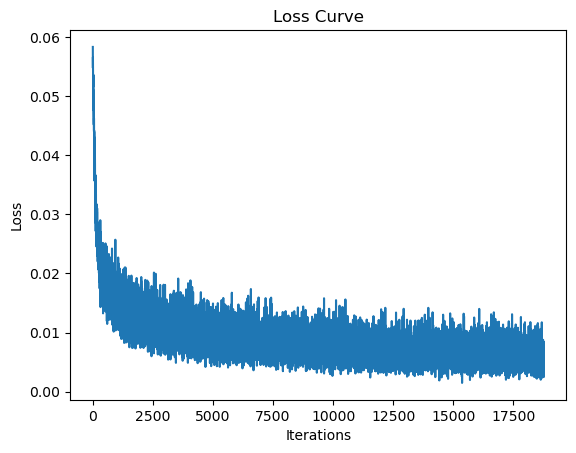

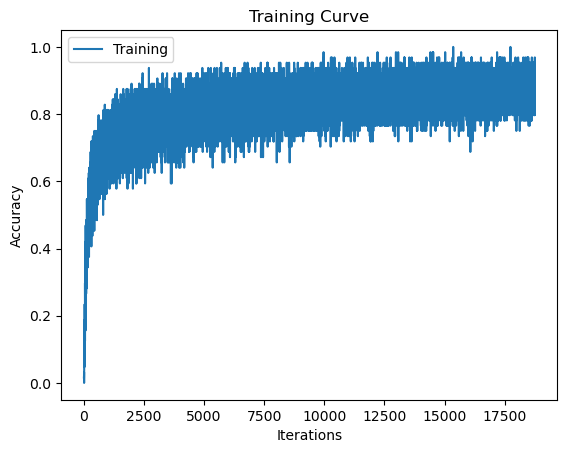

Final Training Accuracy: 0.8809333333333333
Validation Accuracy = 0


RESNET18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [19]:
# use res net 
model = RESNET18()

# hyperparameters
num_epochs = 20
learning_rate = 0.01
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

model.cpu()

epoch: 0
Iteration: 10 Training Accuracy: 0.953125 Loss: 0.002456019865348935
Iteration: 20 Training Accuracy: 0.96875 Loss: 0.0015930567169561982
Iteration: 30 Training Accuracy: 0.953125 Loss: 0.0026750778779387474
Iteration: 40 Training Accuracy: 0.890625 Loss: 0.004841750022023916
Iteration: 50 Training Accuracy: 0.953125 Loss: 0.0018685010727494955
Iteration: 60 Training Accuracy: 0.90625 Loss: 0.0038833809085190296
Iteration: 70 Training Accuracy: 0.90625 Loss: 0.004598974250257015
Iteration: 80 Training Accuracy: 0.96875 Loss: 0.0024193914141505957
Iteration: 90 Training Accuracy: 0.859375 Loss: 0.0059529077261686325
Iteration: 100 Training Accuracy: 0.984375 Loss: 0.0014757458120584488
Iteration: 110 Training Accuracy: 0.953125 Loss: 0.0035659342538565397
Iteration: 120 Training Accuracy: 0.96875 Loss: 0.001166941481642425
Iteration: 130 Training Accuracy: 0.921875 Loss: 0.004291274584829807
Iteration: 140 Training Accuracy: 0.90625 Loss: 0.00576234795153141
Iteration: 150 Trai

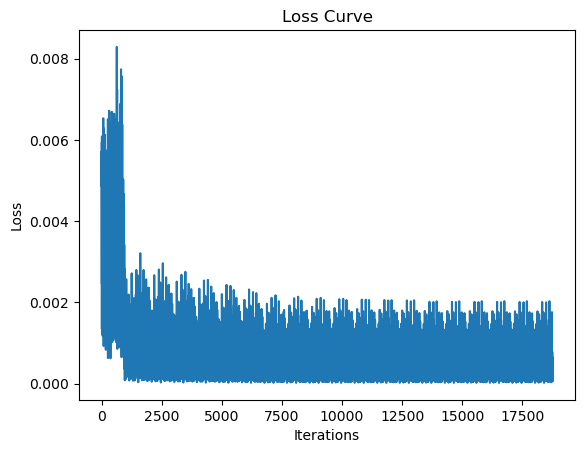

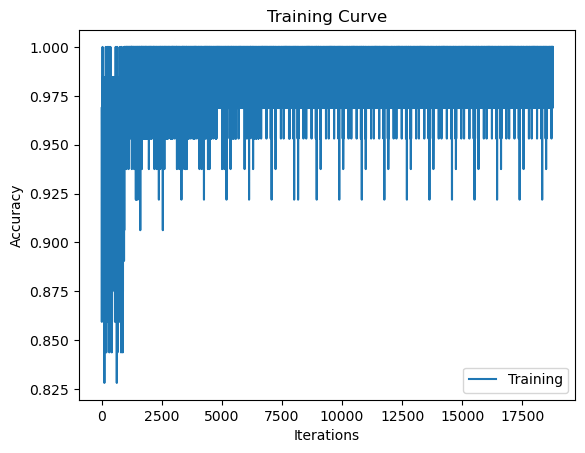

Final Training Accuracy: 0.99185
Validation Accuracy = 0.9288333333333333


RESNET18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [10]:
# use res net 
model = torch.load("full_resnet18_5.pth")

# hyperparameters
num_epochs = 20
learning_rate = 0.001
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

model.cpu()

epoch: 0
Iteration: 10 Training Accuracy: 0.859375 Loss: 0.004849899560213089
Iteration: 20 Training Accuracy: 0.890625 Loss: 0.0038420697674155235
Iteration: 30 Training Accuracy: 0.953125 Loss: 0.0021469087805598974
Iteration: 40 Training Accuracy: 0.921875 Loss: 0.005274956114590168
Iteration: 50 Training Accuracy: 0.84375 Loss: 0.007362027652561665
Iteration: 60 Training Accuracy: 0.859375 Loss: 0.004609496798366308
Iteration: 70 Training Accuracy: 0.984375 Loss: 0.00166227575391531
Iteration: 80 Training Accuracy: 0.890625 Loss: 0.005489868111908436
Iteration: 90 Training Accuracy: 0.953125 Loss: 0.002098931698128581
Iteration: 100 Training Accuracy: 0.96875 Loss: 0.002774599939584732
Iteration: 110 Training Accuracy: 0.921875 Loss: 0.0035131778568029404
Iteration: 120 Training Accuracy: 0.953125 Loss: 0.001518884440883994
Iteration: 130 Training Accuracy: 0.90625 Loss: 0.0035913933534175158
Iteration: 140 Training Accuracy: 0.859375 Loss: 0.005524161271750927
Iteration: 150 Train

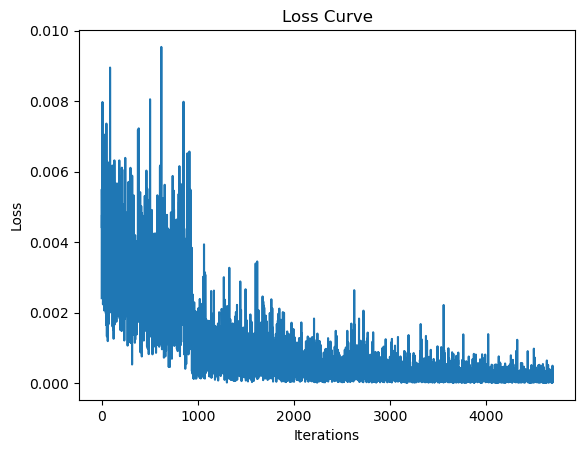

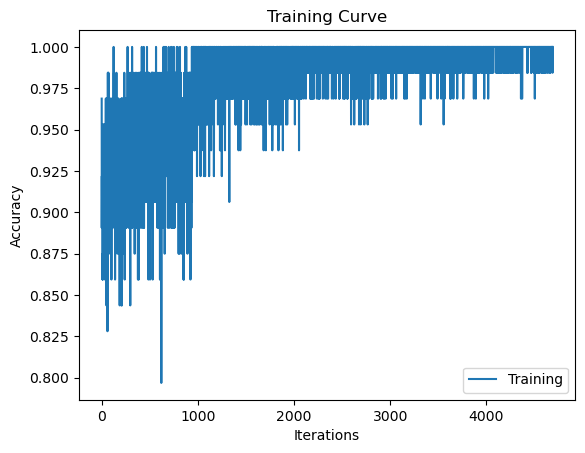

Final Training Accuracy: 0.9983833333333333
Validation Accuracy = 0.9716666666666667


RESNET18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [12]:
# use res net 
model = torch.load("full_resnet18_4.pth")


for param in model.resnet.parameters():
    param.requires_grad = True

# hyperparameters
num_epochs = 5
learning_rate = 0.0001
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

model.cpu()

In [13]:
torch.save(model, 'full_resnet18_100.pth')

In [15]:
out_features1 = 256
out_features2 = 128
out_features3 = 64

p = 0.6

class RESNET18_2(nn.Module):
    def __init__(self):
        super(RESNET18_2, self).__init__()
        # remove fully connected layer at the end
        self.resnet = nn.Sequential(*list(resnet18.children())[:-1])

        # freeze parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        self.fc1 = nn.Linear(resnet18.fc.in_features, out_features1)
        self.fc2 = nn.Linear(out_features1, out_features2)
        self.fc3 = nn.Linear(out_features2, out_features3)
        self.fc4 = nn.Linear(out_features3, 30)

        self.batchnorm1 = nn.BatchNorm1d(out_features1)
        self.batchnorm2 = nn.BatchNorm1d(out_features2)
        self.batchnorm3 = nn.BatchNorm1d(out_features3)

        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        
        # Forward pass through your fully connected layers
        x = F.relu(self.batchnorm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm3(self.fc3(x)))
        x = self.fc4(x)

        return x

epoch: 0
Iteration: 10 Training Accuracy: 0.015625 Loss: 0.053651198744773865
Iteration: 20 Training Accuracy: 0.109375 Loss: 0.05259404703974724
Iteration: 30 Training Accuracy: 0.09375 Loss: 0.051963672041893005
Iteration: 40 Training Accuracy: 0.046875 Loss: 0.052610356360673904
Iteration: 50 Training Accuracy: 0.046875 Loss: 0.05193588510155678
Iteration: 60 Training Accuracy: 0.078125 Loss: 0.05143144726753235
Iteration: 70 Training Accuracy: 0.078125 Loss: 0.0509256012737751
Iteration: 80 Training Accuracy: 0.125 Loss: 0.049269311130046844
Iteration: 90 Training Accuracy: 0.125 Loss: 0.04803340882062912
Iteration: 100 Training Accuracy: 0.125 Loss: 0.0479058176279068
Iteration: 110 Training Accuracy: 0.21875 Loss: 0.04518899694085121
Iteration: 120 Training Accuracy: 0.28125 Loss: 0.042560920119285583
Iteration: 130 Training Accuracy: 0.171875 Loss: 0.045052893459796906
Iteration: 140 Training Accuracy: 0.328125 Loss: 0.0406201034784317
Iteration: 150 Training Accuracy: 0.234375 

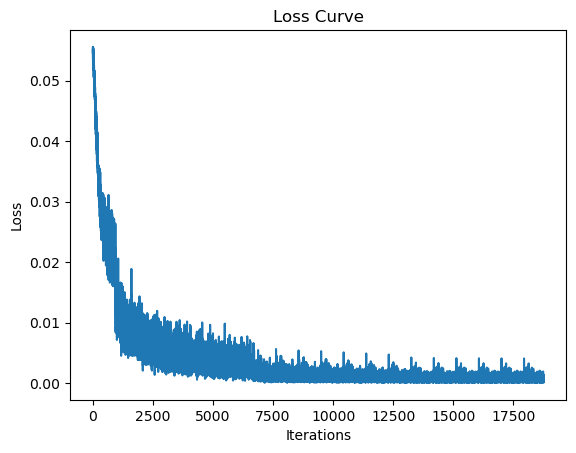

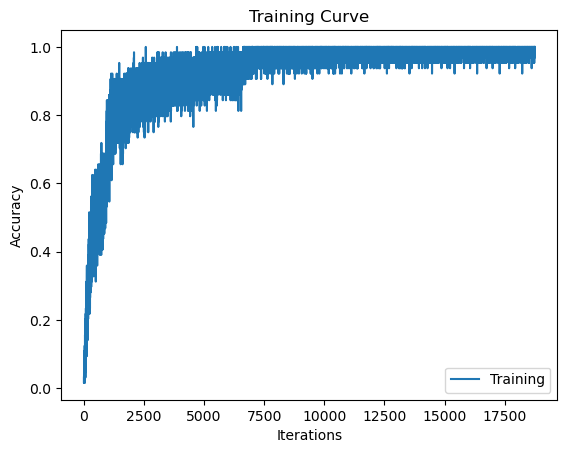

Final Training Accuracy: 0.9896333333333334
Validation Accuracy = 0.9246666666666666


RESNET18_2(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [16]:
# use res net 
model = RESNET18_2()

# hyperparameters
num_epochs = 20
learning_rate = 0.01
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

model.cpu()

In [17]:
torch.save(model, 'full_resnet18_1_1.pth')

epoch: 0
Iteration: 10 Training Accuracy: 0.96875 Loss: 0.0012539136223495007
Iteration: 20 Training Accuracy: 1.0 Loss: 0.00026964934659190476
Iteration: 30 Training Accuracy: 0.984375 Loss: 0.001392528647556901
Iteration: 40 Training Accuracy: 0.96875 Loss: 0.0009054119582287967
Iteration: 50 Training Accuracy: 0.9375 Loss: 0.0019365593325346708
Iteration: 60 Training Accuracy: 0.96875 Loss: 0.0011154626263305545
Iteration: 70 Training Accuracy: 0.984375 Loss: 0.0006532897241413593
Iteration: 80 Training Accuracy: 0.96875 Loss: 0.0012577921152114868
Iteration: 90 Training Accuracy: 0.984375 Loss: 0.0007886758539825678
Iteration: 100 Training Accuracy: 0.984375 Loss: 0.0005693825660273433
Iteration: 110 Training Accuracy: 1.0 Loss: 0.0003563984646461904
Iteration: 120 Training Accuracy: 0.984375 Loss: 0.00040823937160894275
Iteration: 130 Training Accuracy: 0.953125 Loss: 0.0020719568710774183
Iteration: 140 Training Accuracy: 0.953125 Loss: 0.0025311096105724573
Iteration: 150 Traini

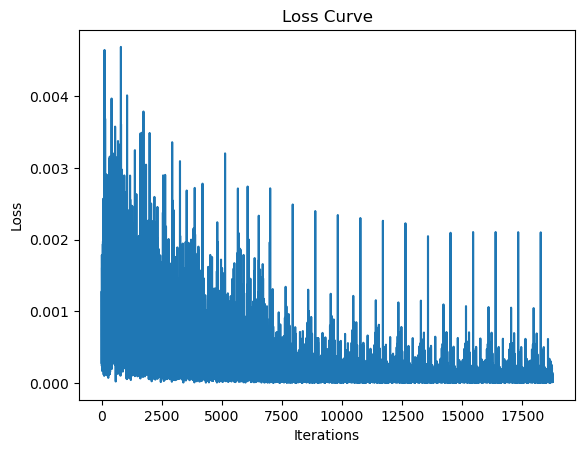

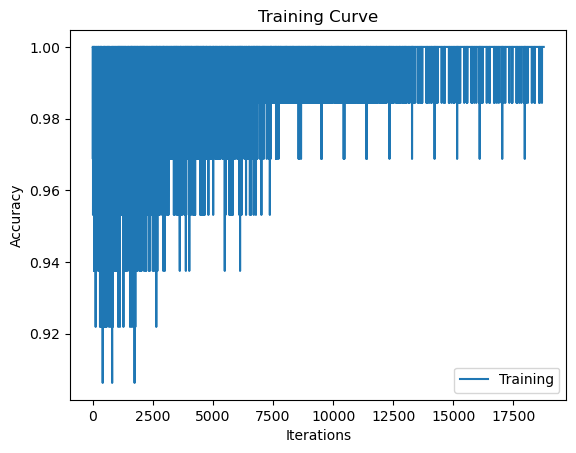

Final Training Accuracy: 0.9997166666666667
Validation Accuracy = 0.9291666666666667


RESNET18_2(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [18]:
# use res net 
model = torch.load("full_resnet18_1_1.pth")

# hyperparameters
num_epochs = 20
learning_rate = 0.005
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

model.cpu()

In [19]:
torch.save(model, 'full_resnet18_1_2.pth')